In [1]:
import os
import glob

import pandas as pd
import numpy as np

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import Align 
from Bio import SeqIO
from Bio import AlignIO

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as patches

import verify_sanger.sanger_utilities as vs

import seaborn as sns
sns.set()
# set global default style:
sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True, })
#sns.set_style({"axes.labelsize": 20, "xtick.labelsize" : 16, "ytick.labelsize" : 16})

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.edgecolor'] = 'k'

plt.rcParams['figure.max_open_warning'] = False

%load_ext autoreload
%autoreload 2

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'C:\\Users\\djross\\Documents\\Python Scripts\\verify_sanger\\example data'

In [3]:
data_dir = notebook_dir + '\\data'
data_dir

'C:\\Users\\djross\\Documents\\Python Scripts\\verify_sanger\\example data\\data'

In [4]:
clone_file = 'Sanger clones.csv'

In [5]:
# Get the input file info from the .csv file
os.chdir(data_dir)
align_frame = pd.read_csv(clone_file)
align_frame['forward_sanger_file'] = [ x+'.ab1' if type(x) is str else '' for x in  align_frame.forward_sanger_file ]
align_frame['reverse_sanger_file'] = [ x+'.ab1' if type(x) is str else '' for x in  align_frame.reverse_sanger_file ]
align_frame

,variant,clone,forward_sanger_file,reverse_sanger_file
0,pVER-IPTG-WT(F161V/I83F),A,1FCFDAA056.ab1,1FCFDAA032.ab1
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1
3,pVER-IPTG-WT(G200C),B,1FCDDAA050.ab1,1FCDDAA028.ab1
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1
5,pVER-IPTG-WT(G200C/I83F),B,1FCFDAA061.ab1,1FCFDAA037.ab1
6,pVER-IPTG-WT(G200C/S97T),A,1FCFDAA004.ab1,1FCDDAA080.ab1
7,pVER-IPTG-WT(G200C/S97T),B,1FCFDAA003.ab1,1FCDDAA079.ab1
8,pVER-IPTG-WT(I83M/S69T),A,1FCFDAA064.ab1,1FCFDAA040.ab1
9,pVER-IPTG-WT(I83M/S69T),B,1FCFDAA063.ab1,1FCFDAA039.ab1


In [6]:
# Check for duplicate or missing file names
df = align_frame[align_frame.forward_sanger_file=='']
df = df[df.reverse_sanger_file!='']
display(df)

df = align_frame[align_frame.forward_sanger_file!='']
df = df[df.reverse_sanger_file=='']
display(df)

,variant,clone,forward_sanger_file,reverse_sanger_file


,variant,clone,forward_sanger_file,reverse_sanger_file


In [7]:
df = align_frame[align_frame.forward_sanger_file!='']
print(len(df))
print(len(np.unique(df.forward_sanger_file)))
print(len(np.unique(df.reverse_sanger_file)))

14
14
14


In [8]:
# Get the reference sequence
os.chdir(data_dir)
ref_record = SeqIO.read('LacI-WT_with_adapters.gb', "genbank")
ref_feature = 'lacI CDS'

reference_feat = None
for feat in ref_record.features:
    if feat.qualifiers['label'][0] == ref_feature:
        reference_feat = feat
        break

# These are the start and end positions of the insert CDS in the reference sequence 
ref_b0, ref_b1 = reference_feat.location.start.position, reference_feat.location.end.position
ref_length = ref_b1 - ref_b0

len(ref_record), ref_length, reference_feat

(1217,
 1083,
 SeqFeature(FeatureLocation(ExactPosition(80), ExactPosition(1163), strand=1), type='CDS'))

In [9]:
# Run pairwise alignment of forward and reverse Sanger reads
os.chdir(data_dir)

trim = 0.01

alignment_list = []
is_good_sanger = []
sanger_start = []

for row_ind, row in align_frame.iterrows():
    if row.forward_sanger_file!='':
        try:
            record1 = SeqIO.read(row.forward_sanger_file, "abi")
            
            sang_start = record1.annotations['run_start']
            sanger_start.append(sang_start)
            
            ind = vs.mott_trimming_fr(record1, trim=trim)
            record1 = vs.slice_sanger(record1, ind[0], ind[1]+1)

            record2 = SeqIO.read(row.reverse_sanger_file, "abi")
            ind = vs.mott_trimming_fr(record2, trim=trim)
            record2 = vs.slice_sanger(record2, ind[0], ind[1]+1)
            record2 = vs.sanger_reverse_complement(record2)

            print(f'{row_ind}, {row.variant} clone {row.clone}')
            a = vs.align_sanger(record1, record2, verbose=True)
            alignment_list.append(a)
            
            is_good = vs.is_good_sanger(a)
            is_good_sanger.append(is_good)
            print(f'is_good_sanger: {is_good}')
            print()
        except FileNotFoundError:
            alignment_list.append(None)
            is_good_sanger.append(None)
            sanger_start.append(None)
    else:
        alignment_list.append(None)
        is_good_sanger.append(None)
        sanger_start.append(None)
        

align_frame['alignment'] = alignment_list
align_frame['is_good_sanger'] = is_good_sanger
align_frame['sanger_start'] = sanger_start
        
os.chdir(notebook_dir)

0, pVER-IPTG-WT(F161V/I83F) clone A
2 alignment(s) found with score: 1253.0
(((0, 4), (4, 253)), ((676, 680), (681, 930)))
1 gap(s) in sequence no. 1
253 matches in alignment
0 mismatches in alignment
is_good_sanger: True

1, pVER-IPTG-WT(F161V/I83F) clone B
1 alignment(s) found with score: 1070.0
(((510, 724),), ((0, 214),))
no gaps
214 matches in alignment
0 mismatches in alignment
is_good_sanger: True

2, pVER-IPTG-WT(G200C) clone A
1 alignment(s) found with score: 1535.0
(((409, 716),), ((0, 307),))
no gaps
307 matches in alignment
0 mismatches in alignment
is_good_sanger: True

3, pVER-IPTG-WT(G200C) clone B
2 alignment(s) found with score: 0.0
((), ())
no gaps
0 matches in alignment
0 mismatches in alignment
is_good_sanger: False

4, pVER-IPTG-WT(G200C/I83F) clone A
3 alignment(s) found with score: 1243.0
(((611, 832), (833, 863)), ((0, 221), (221, 251)))
1 gap(s) in sequence no. 2
251 matches in alignment
0 mismatches in alignment
is_good_sanger: True

5, pVER-IPTG-WT(G200C/I83F

In [10]:
display_cols = ['variant', 'clone', 'forward_sanger_file', 'reverse_sanger_file',
                'sanger_start', 'is_good_sanger']

In [11]:
align_frame[align_frame.is_good_sanger==True][display_cols]

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger
0,pVER-IPTG-WT(F161V/I83F),A,1FCFDAA056.ab1,1FCFDAA032.ab1,2021-04-26 19:59:48,True
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1,2021-04-26 19:59:48,True
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1,2021-05-14 02:41:37,True
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1,2021-04-26 19:59:48,True
8,pVER-IPTG-WT(I83M/S69T),A,1FCFDAA064.ab1,1FCFDAA040.ab1,2021-04-26 19:59:48,True
10,pVER-IPTG-WT(I83M/S97T/V136E),A,1FCFDAA058.ab1,1FCFDAA034.ab1,2021-04-26 19:59:48,True
11,pVER-IPTG-WT(I83M/S97T/V136E),B,1FCFDAA057.ab1,1FCFDAA033.ab1,2021-04-26 19:59:48,True
12,pVER-IPTG-WT(Q181H/S70R),A,1FCFDAA068.ab1,1FCFDAA044.ab1,2021-04-26 19:59:48,True
13,pVER-IPTG-WT(Q181H/S70R),B,1FCFDAA067.ab1,1FCFDAA043.ab1,2021-04-26 19:59:48,True


In [12]:
# Run pairwise alignment between reference sequence and consensus from Sanger
ref_alignment = []
mismatch_list = []
good_insert = []
gap_in_ref = []

max_mutations = len(ref_record) - ref_length + 20
print(f'max_mutations: {max_mutations}')
print()

for row_ind, row in align_frame.iterrows():
    
    a = row.alignment
    
    if row.alignment is not None: #row.is_good_sanger:
        print(f'{row_ind}, {row.variant} clone {row.clone}')
        test_seq = row.alignment.consensus_seq.reverse_complement()
        ref_align = vs.align_sanger(ref_record, test_seq, verbose=True, ungap=True)
        
        ref_alignment.append(ref_align)
        mis_match = vs.num_matches(ref_align)
        gap_count = vs.num_gaps(ref_align)
        
        if row.is_good_sanger:
            good_ins = mis_match[0]>=len(ref_record)-max_mutations
        else:
            good_ins = None
        good_insert.append(good_ins)
        mismatch_list.append(mis_match)
        gap = gap_count>0
        gap_in_ref.append(gap)
        
        print(f'is_good_sanger: {row.is_good_sanger}')
        print(f'is_good_insert: {good_ins}')
        print(f'gap_in_ref_align: {gap}')
        print()
        
    else:
        ref_alignment.append(None)
        good_insert.append(None)
        gap_in_ref.append(None)
        
align_frame['ref_alignment'] = ref_alignment
align_frame['is_good_insert'] = good_insert
align_frame['gap_in_ref_align'] = gap_in_ref

max_mutations: 154

0, pVER-IPTG-WT(F161V/I83F) clone A
1 alignment(s) found with score: 11.0
(((0, 3), (3, 5), (5, 9), (10, 11), (14, 17)), ((1362, 1365), (1366, 1368), (1369, 1373), (1373, 1374), (1374, 1377)))
2 gap(s) in sequence no. 1
multi-base gap in sequence no. 2
13 matches in alignment
0 mismatches in alignment
is_good_sanger: True
is_good_insert: False
gap_in_ref_align: True

1, pVER-IPTG-WT(F161V/I83F) clone B
1 alignment(s) found with score: 6057.0
(((0, 1217),), ((45, 1262),))
no gaps
1215 matches in alignment
2 mismatches in alignment
is_good_sanger: True
is_good_insert: True
gap_in_ref_align: False

2, pVER-IPTG-WT(G200C) clone A
1 alignment(s) found with score: 6071.0
(((0, 1217),), ((48, 1265),))
no gaps
1216 matches in alignment
1 mismatches in alignment
is_good_sanger: True
is_good_insert: True
gap_in_ref_align: False

3, pVER-IPTG-WT(G200C) clone B
1 alignment(s) found with score: 3156.0
(((0, 634),), ((602, 1236),))
no gaps
633 matches in alignment
1 mismatches in

In [13]:
display_cols += ['is_good_insert', 'gap_in_ref_align']

In [14]:
align_frame[align_frame.is_good_insert==True][display_cols]

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1,2021-04-26 19:59:48,True,True,False
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1,2021-05-14 02:41:37,True,True,False
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1,2021-04-26 19:59:48,True,True,False
10,pVER-IPTG-WT(I83M/S97T/V136E),A,1FCFDAA058.ab1,1FCFDAA034.ab1,2021-04-26 19:59:48,True,True,False
11,pVER-IPTG-WT(I83M/S97T/V136E),B,1FCFDAA057.ab1,1FCFDAA033.ab1,2021-04-26 19:59:48,True,True,False
13,pVER-IPTG-WT(Q181H/S70R),B,1FCFDAA067.ab1,1FCFDAA043.ab1,2021-04-26 19:59:48,True,True,True


In [15]:
# Find mutation codes
mut_codes = []
indel_codes = []

for row_ind, row in align_frame.iterrows():
    
    a = row.alignment
    
    if (row.is_good_sanger) and (row.is_good_insert):
        print(f'{row_ind}, {row.variant} clone {row.clone}')
        
        amino_align, subs, indels = vs.find_mutations_vs_reference(row.ref_alignment, 'lacI CDS', verbose=True)
        print(subs)
        print(indels)
        print()
        
        mut_codes.append(subs)
        indel_codes.append(indels)
    else:
        mut_codes.append([])
        indel_codes.append([])
        
align_frame['substitution_codes'] = mut_codes
align_frame['indel_codes'] = indel_codes

1, pVER-IPTG-WT(F161V/I83F) clone B
1 alignment(s) found with score: 1777.0
(((0, 361),), ((0, 361),))
no gaps
359 matches in alignment
2 mismatches in alignment
['I83F', 'F161V']
[]

2, pVER-IPTG-WT(G200C) clone A
1 alignment(s) found with score: 1791.0
(((0, 361),), ((0, 361),))
no gaps
360 matches in alignment
1 mismatches in alignment
['G200C']
[]

4, pVER-IPTG-WT(G200C/I83F) clone A
1 alignment(s) found with score: 1777.0
(((0, 361),), ((0, 361),))
no gaps
359 matches in alignment
2 mismatches in alignment
['I83F', 'G200C']
[]

10, pVER-IPTG-WT(I83M/S97T/V136E) clone A
1 alignment(s) found with score: 1749.0
(((0, 361),), ((0, 361),))
no gaps
357 matches in alignment
4 mismatches in alignment
['I83M', 'S97T', 'V136E', 'L233X']
[]

11, pVER-IPTG-WT(I83M/S97T/V136E) clone B
1 alignment(s) found with score: 1749.0
(((0, 361),), ((0, 361),))
no gaps
357 matches in alignment
4 mismatches in alignment
['I83M', 'S97T', 'V136E', 'Q153X']
[]

13, pVER-IPTG-WT(Q181H/S70R) clone B
2 alignmen

C:\Users\djross\Anaconda3\lib\site-packages\Bio\Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [16]:
display_cols += ['substitution_codes', 'indel_codes']

In [17]:
align_frame[(align_frame.is_good_sanger==True)&(align_frame.is_good_insert==True)][display_cols]

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, F161V]",[]
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1,2021-05-14 02:41:37,True,True,False,[G200C],[]
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, G200C]",[]
10,pVER-IPTG-WT(I83M/S97T/V136E),A,1FCFDAA058.ab1,1FCFDAA034.ab1,2021-04-26 19:59:48,True,True,False,"[I83M, S97T, V136E, L233X]",[]
11,pVER-IPTG-WT(I83M/S97T/V136E),B,1FCFDAA057.ab1,1FCFDAA033.ab1,2021-04-26 19:59:48,True,True,False,"[I83M, S97T, V136E, Q153X]",[]
13,pVER-IPTG-WT(Q181H/S70R),B,1FCFDAA067.ab1,1FCFDAA043.ab1,2021-04-26 19:59:48,True,True,True,[],[]


In [18]:
align_frame[(align_frame.is_good_sanger==True)&(align_frame.is_good_insert==False)][display_cols]

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes
0,pVER-IPTG-WT(F161V/I83F),A,1FCFDAA056.ab1,1FCFDAA032.ab1,2021-04-26 19:59:48,True,False,True,[],[]
8,pVER-IPTG-WT(I83M/S69T),A,1FCFDAA064.ab1,1FCFDAA040.ab1,2021-04-26 19:59:48,True,False,False,[],[]
12,pVER-IPTG-WT(Q181H/S70R),A,1FCFDAA068.ab1,1FCFDAA044.ab1,2021-04-26 19:59:48,True,False,True,[],[]


In [19]:
# Check mutation codes to see if they match expectations
# If there is an indeterminate amino acid code, re-mark is_good_sanger as False
# 
good_sanger = []
correct_insert = []

for row_ind, row in align_frame.iterrows():
    good_ins = row.is_good_insert
    good_sang = row.is_good_sanger
    correct_ins = None
    
    if good_ins and good_sang:
        print(f'{row_ind}, {row.variant} clone {row.clone}')
        
        added_codes = []
        if '157' in row.variant:
            added_codes = ['V95M', 'A214V']
        
        expected_mutations = vs.mutation_codes_from_name(row.variant, added_codes=added_codes)
        if expected_mutations==row.substitution_codes:
            print('Substitutions are correct') #: {row.substitution_codes}')
            correct_ins = True
        else:
            solid_mut = [x for x in row.substitution_codes if x[-1]!='X']
            if expected_mutations==solid_mut:
                print(f'Sanger result contains indeterminate amino acids: {row.substitution_codes}')
                good_sang = False
            else:
                if row.gap_in_ref_align:
                    print(f'Sanger result contains frame shift: {row.substitution_codes}')
                else:
                    print(f'Sanger result contains incorrect amino acids: {row.substitution_codes}')
                correct_ins = False
        print()
    correct_insert.append(correct_ins)
    good_sanger.append(good_sang)
    
align_frame['has_correct_insert'] = correct_insert
align_frame['is_good_sanger'] = good_sanger

display_cols.append('has_correct_insert')

1, pVER-IPTG-WT(F161V/I83F) clone B
Substitutions are correct

2, pVER-IPTG-WT(G200C) clone A
Substitutions are correct

4, pVER-IPTG-WT(G200C/I83F) clone A
Substitutions are correct

10, pVER-IPTG-WT(I83M/S97T/V136E) clone A
Sanger result contains indeterminate amino acids: ['I83M', 'S97T', 'V136E', 'L233X']

11, pVER-IPTG-WT(I83M/S97T/V136E) clone B
Sanger result contains indeterminate amino acids: ['I83M', 'S97T', 'V136E', 'Q153X']

13, pVER-IPTG-WT(Q181H/S70R) clone B
Sanger result contains frame shift: []



In [20]:
df = align_frame[(align_frame.is_good_sanger==False)&(align_frame.is_good_insert==True)]
display(df[display_cols])
df = align_frame[(align_frame.is_good_sanger==True)&(align_frame.is_good_insert==True)]
display(df[display_cols])
df = df[df.has_correct_insert]
df[display_cols]

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes,has_correct_insert
10,pVER-IPTG-WT(I83M/S97T/V136E),A,1FCFDAA058.ab1,1FCFDAA034.ab1,2021-04-26 19:59:48,False,True,False,"[I83M, S97T, V136E, L233X]",[],None
11,pVER-IPTG-WT(I83M/S97T/V136E),B,1FCFDAA057.ab1,1FCFDAA033.ab1,2021-04-26 19:59:48,False,True,False,"[I83M, S97T, V136E, Q153X]",[],None


,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes,has_correct_insert
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, F161V]",[],True
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1,2021-05-14 02:41:37,True,True,False,[G200C],[],True
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, G200C]",[],True
13,pVER-IPTG-WT(Q181H/S70R),B,1FCFDAA067.ab1,1FCFDAA043.ab1,2021-04-26 19:59:48,True,True,True,[],[],False


,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes,has_correct_insert
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, F161V]",[],True
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1,2021-05-14 02:41:37,True,True,False,[G200C],[],True
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, G200C]",[],True


In [21]:
# Plots to show for different conditions:
#     Bad Sanger, unknown insert
#         zoom_out_plot
#         compare_to_ref_plot
#     Bad Sanger, good insert
#         zoom_out_plot
#         zoom_in_plot(sanger_alignment)
#         compare_to_ref_plot
#         zoom_in_plot(ref_alignment)
#     Good Sanger, bad insert
#         zoom_out_plot
#         compare_to_ref_plot
#     Good Sanger, good insert, but wrong insert
#         zoom_out_plot
#         zoom_in_plot(sanger_alignment)
#         compare_to_ref_plot
#         zoom_in_plot(ref_alignment)
#     Good Sanger, good insert, and correct insert
#         zoom_out_plot
#         zoom_in_plot(sanger_alignment)
#         compare_to_ref_plot
#         zoom_in_plot(ref_alignment)

In [22]:
align_frame['plotted'] = False

0, pVER-IPTG-WT(F161V/I83F) clone A
    1FCFDAA056.ab1, 1FCFDAA032.ab1
Good Sanger, Bad insert
1 mismatches or gaps in Sanger alignment
Frame shift mutation in Reference alignment

1, pVER-IPTG-WT(F161V/I83F) clone B
    1FCFDAA055.ab1, 1FCFDAA031.ab1
Good Sanger, Good insert, and correct insert
0 mismatches or gaps in Sanger alignment
2 mismatches or gaps in Reference alignment
TGTCGCGGCGATTAAATCTCG
||||||||||.||||||||||
TGTCGCGGCGTTTAAATCTCG
CAGTATTATTTTCTCCCATGA
||||||||||.||||||||||
CAGTATTATTGTCTCCCATGA

2, pVER-IPTG-WT(G200C) clone A
    1FCDDAA051.ab1, 1FCDDAA029.ab1
Good Sanger, Good insert, and correct insert
0 mismatches or gaps in Sanger alignment
1 mismatches or gaps in Reference alignment
GCGTCTGGCTGGCTGGCATAA
||||||||||.||||||||||
GCGTCTGGCTTGCTGGCATAA

3, pVER-IPTG-WT(G200C) clone B
    1FCDDAA050.ab1, 1FCDDAA028.ab1
Bad Sanger
0 mismatches or gaps in Sanger alignment
1 mismatches or gaps in Reference alignment

4, pVER-IPTG-WT(G200C/I83F) clone A
    1FCFDAA062.ab1, 1FC

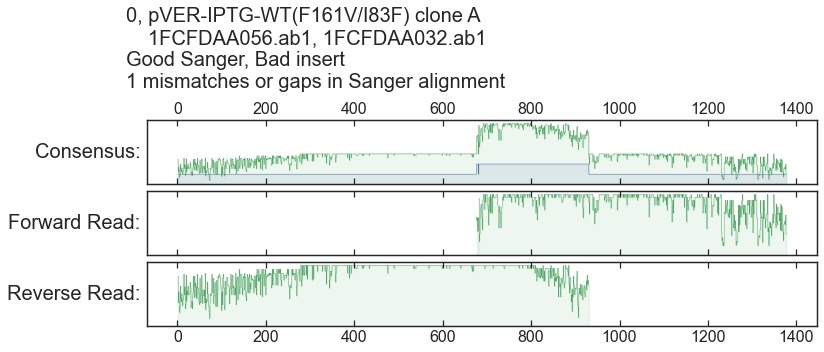

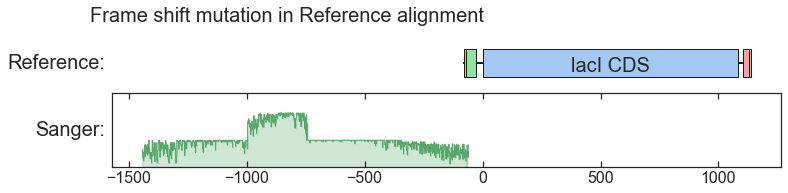

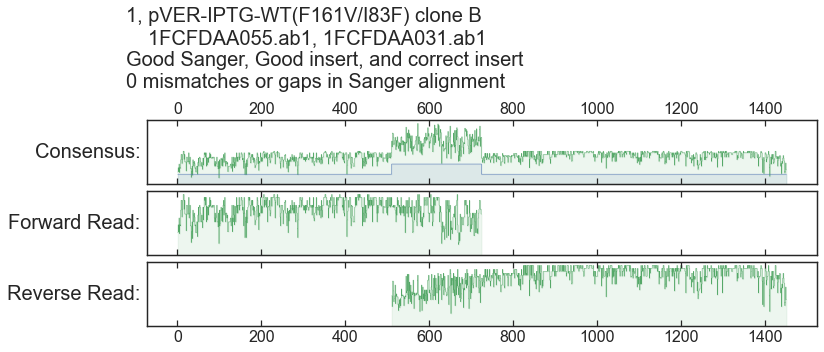

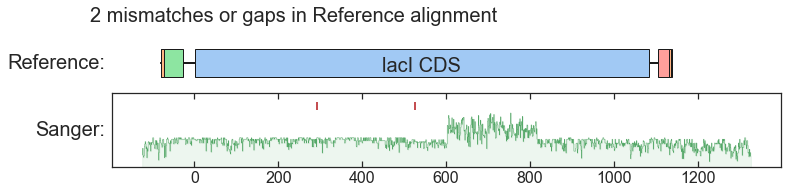

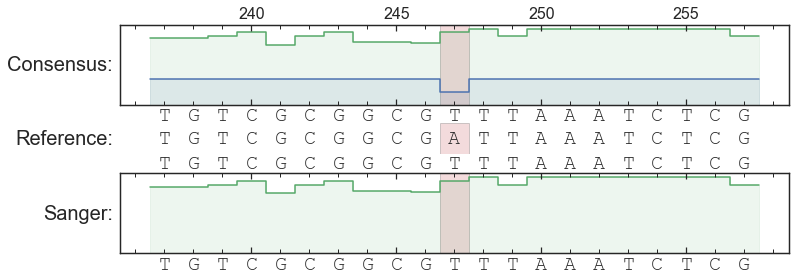

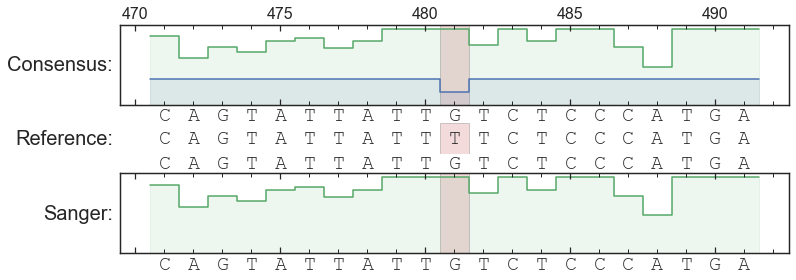

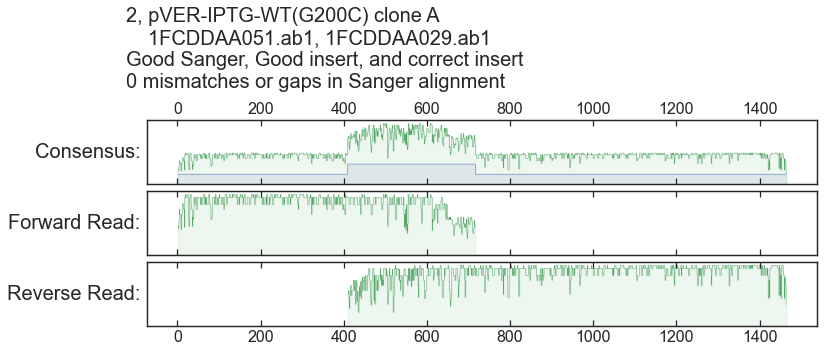

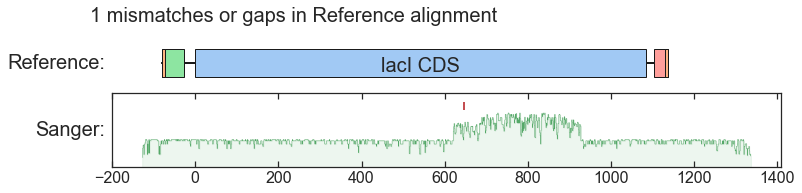

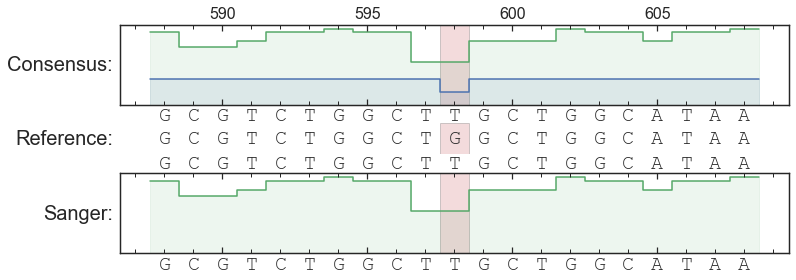

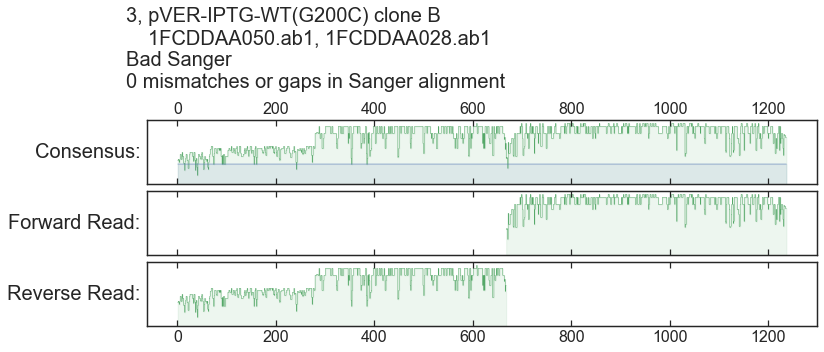

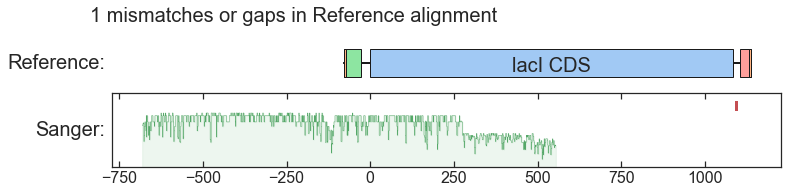

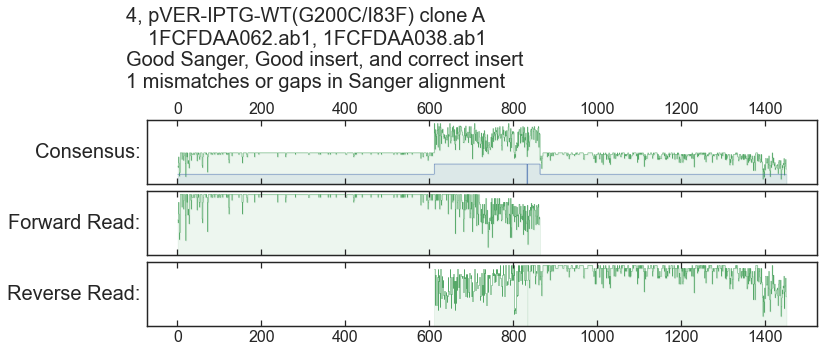

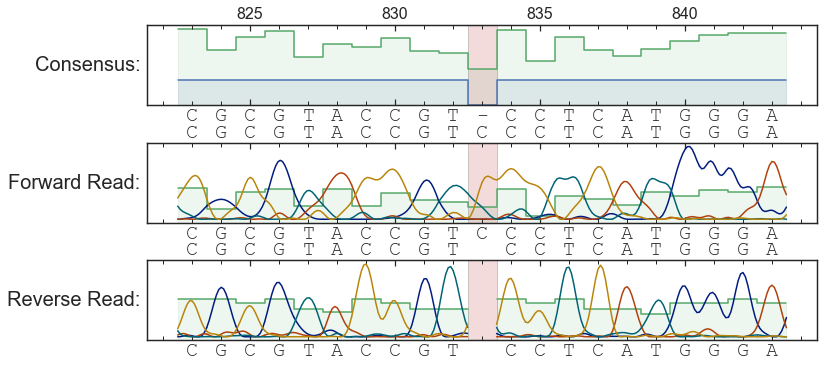

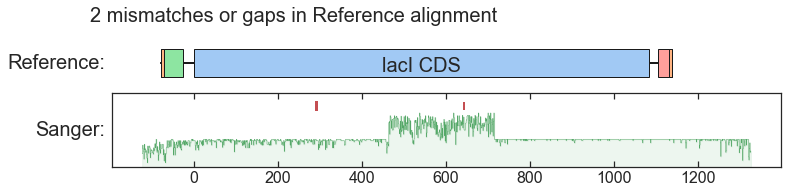

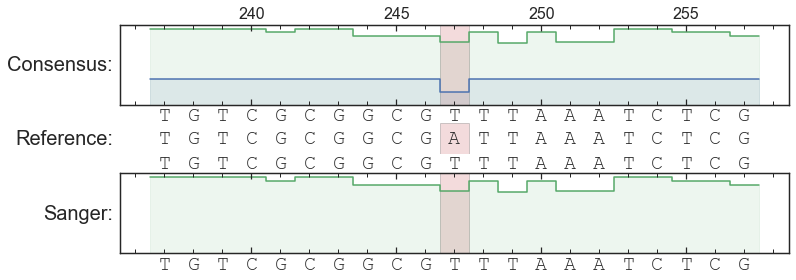

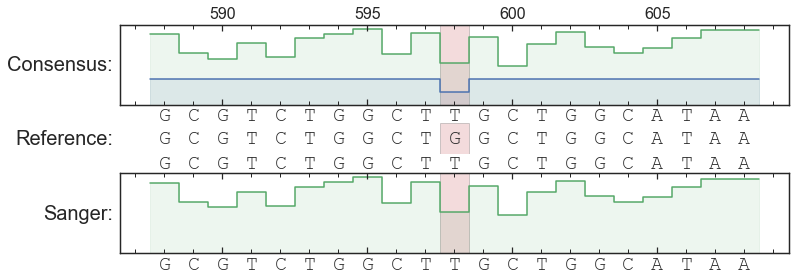

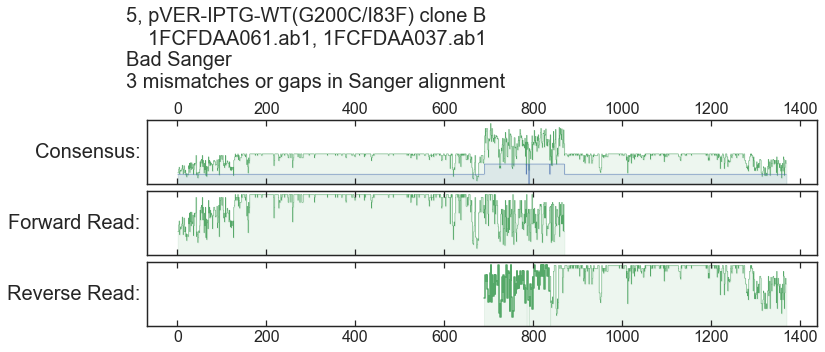

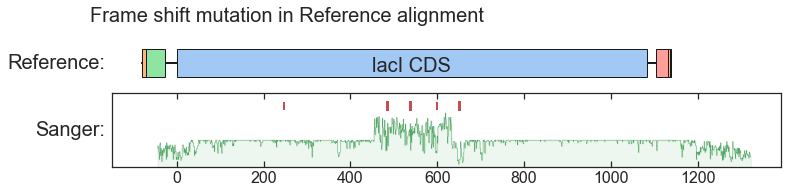

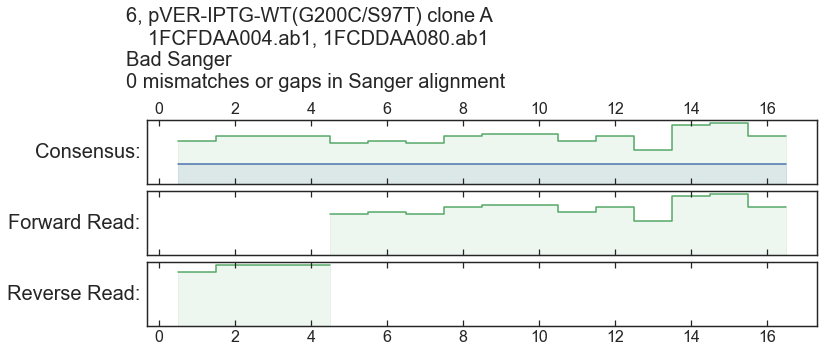

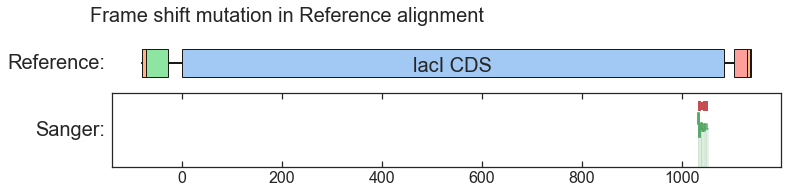

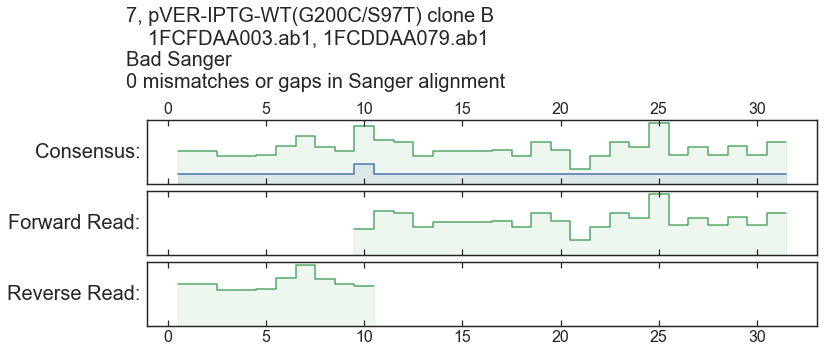

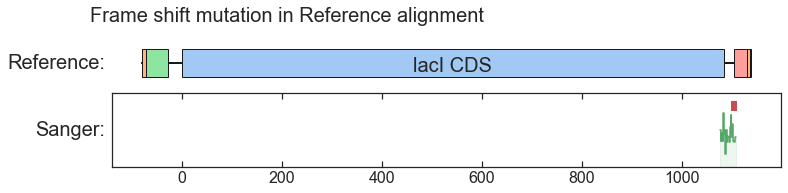

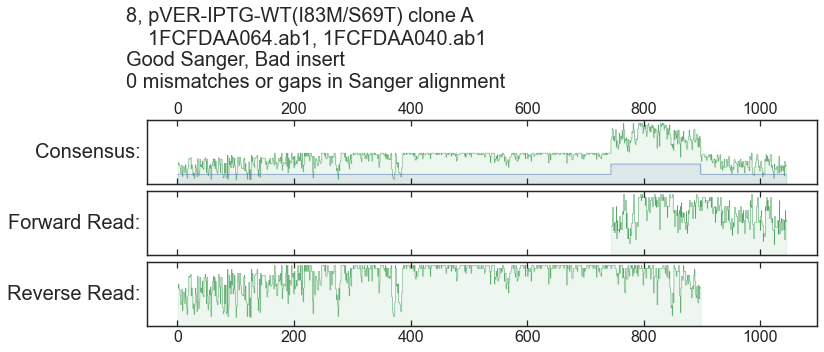

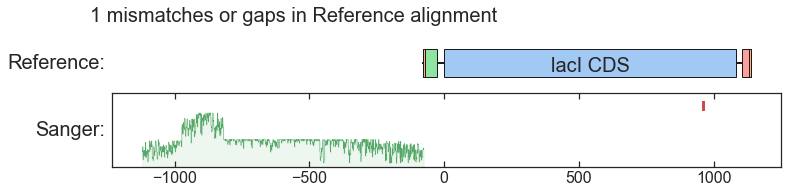

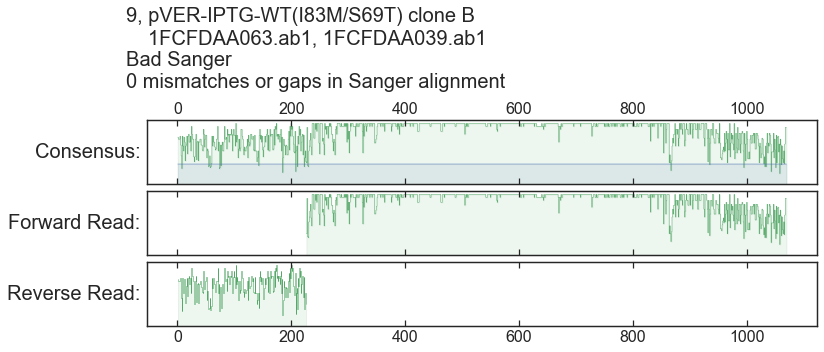

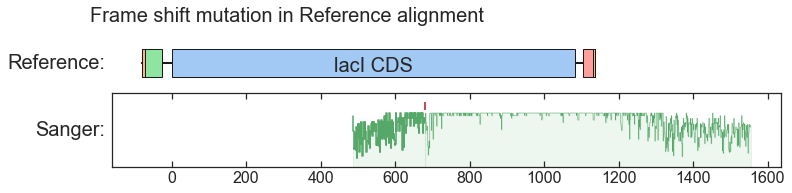

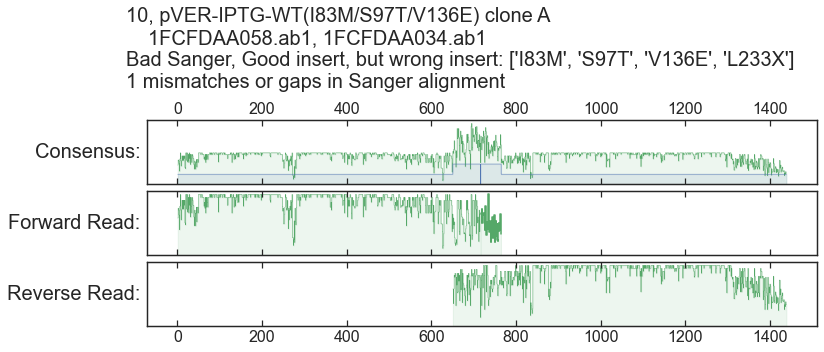

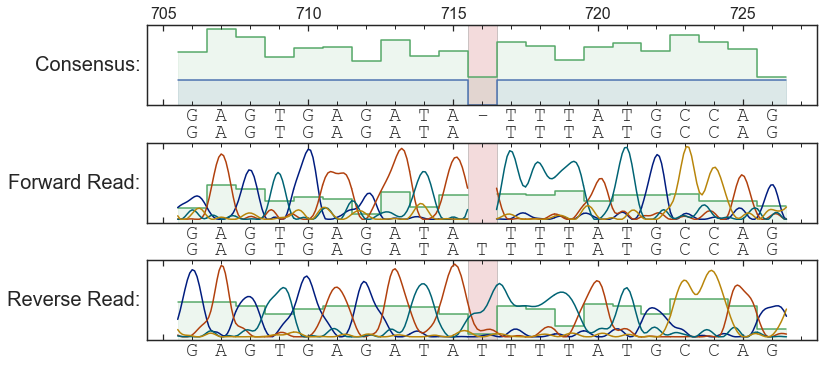

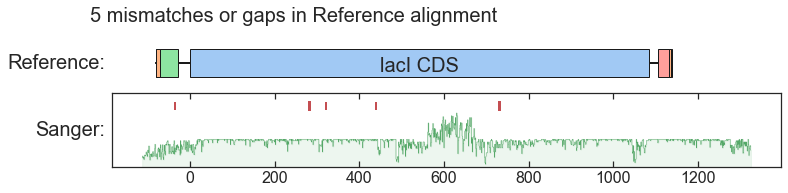

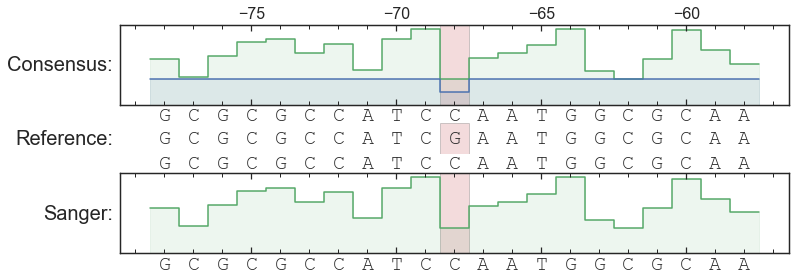

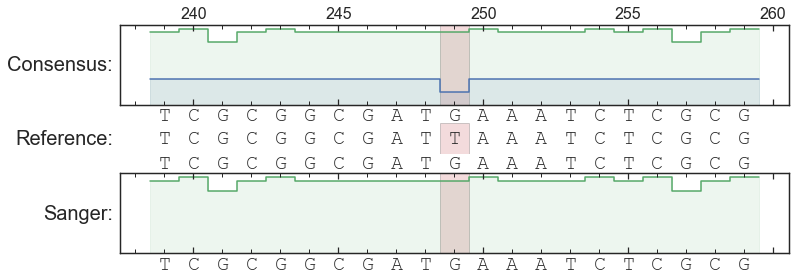

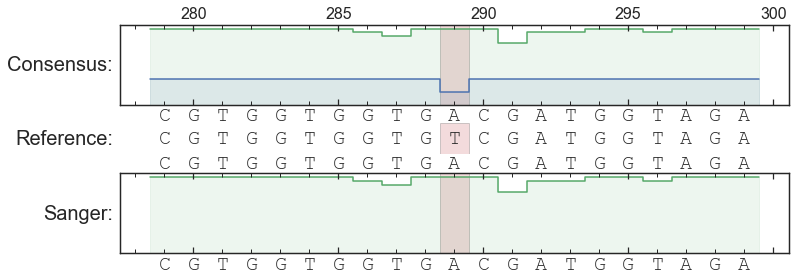

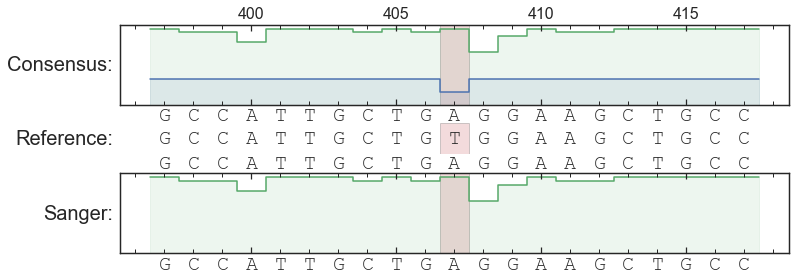

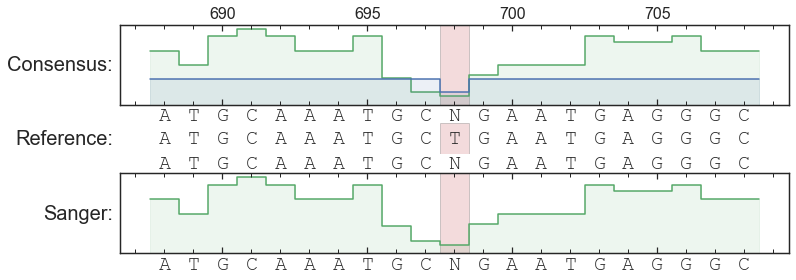

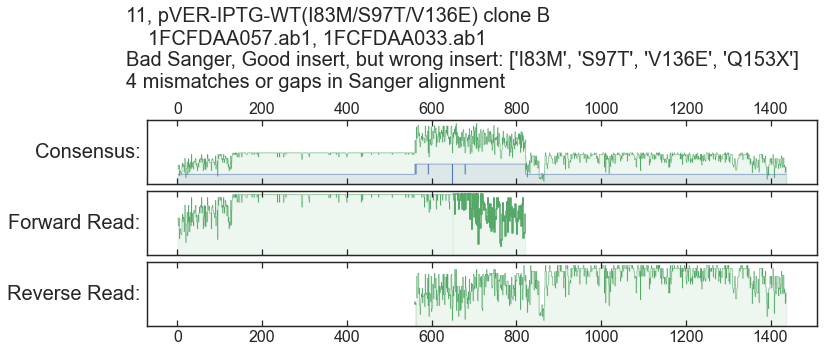

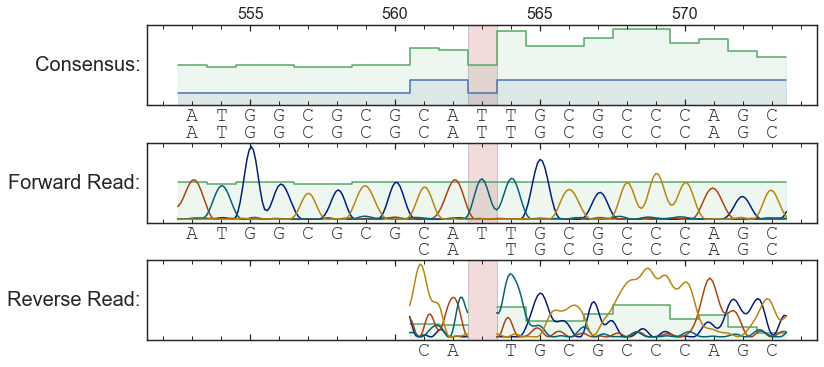

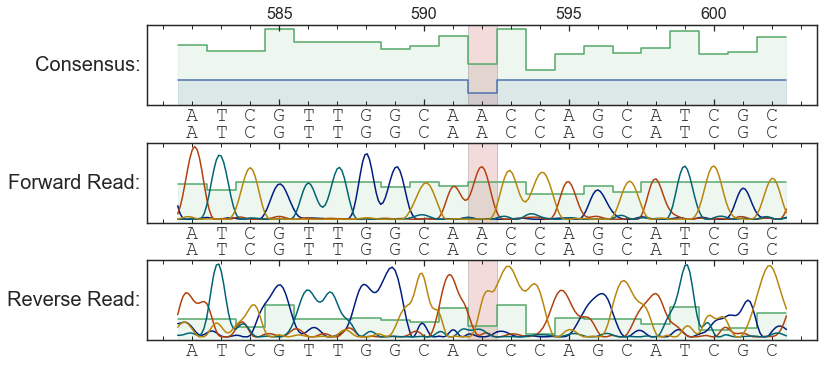

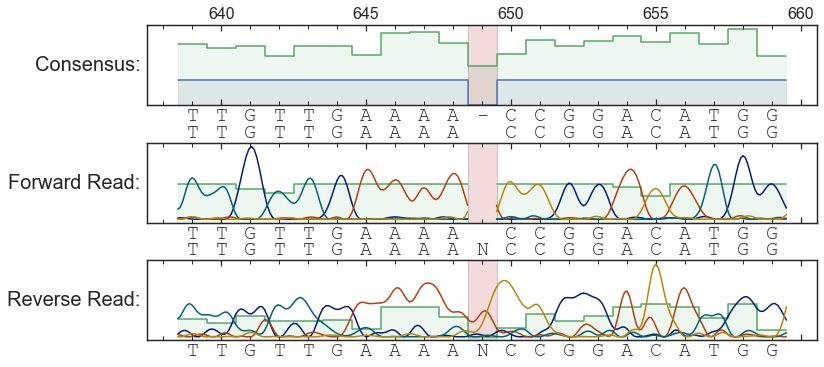

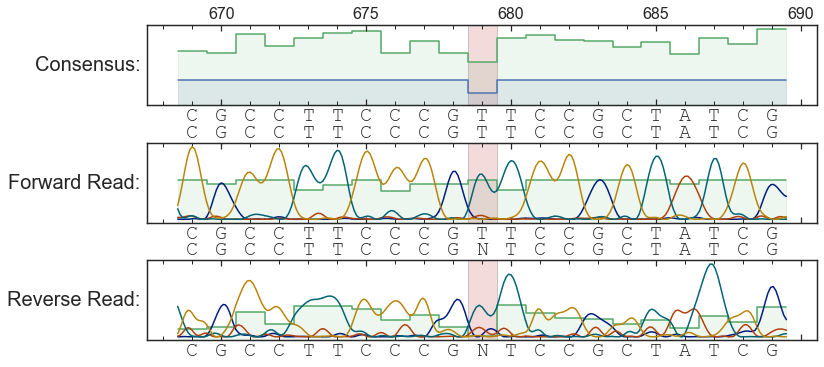

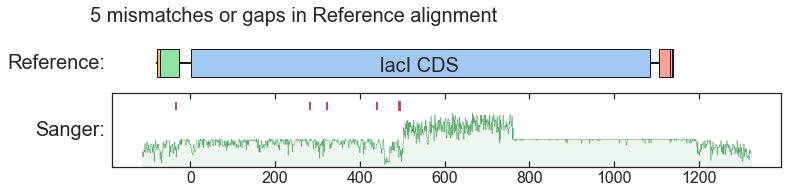

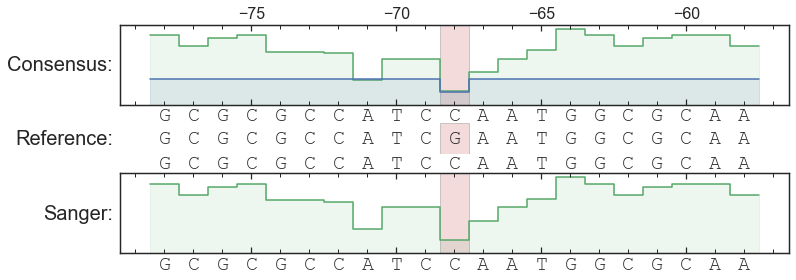

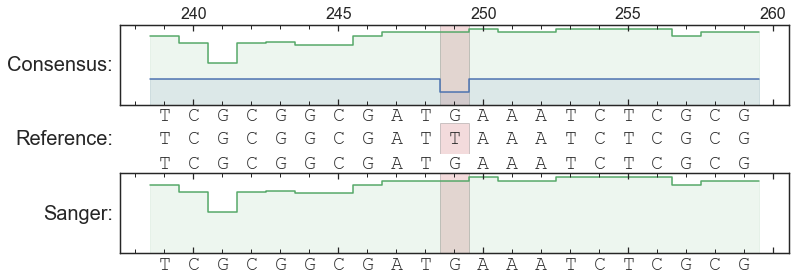

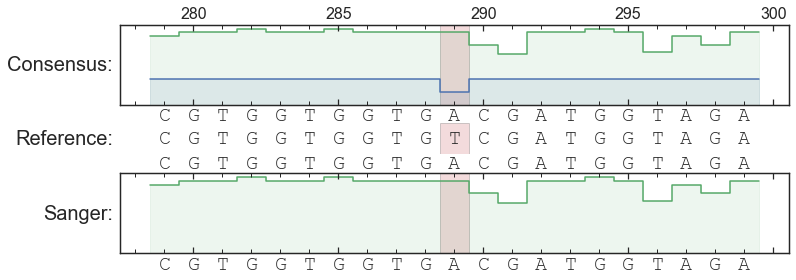

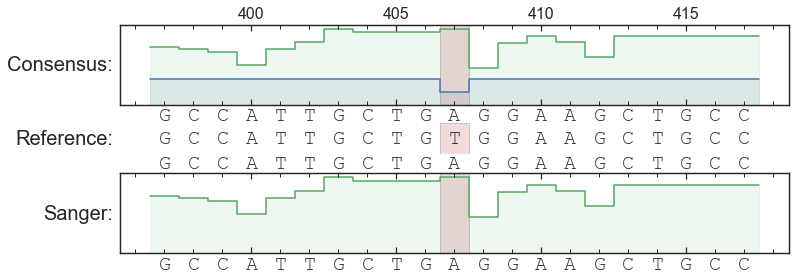

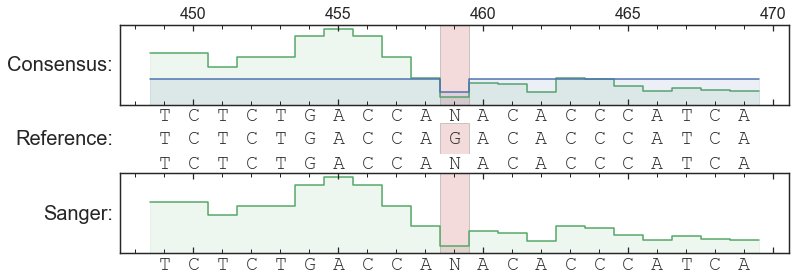

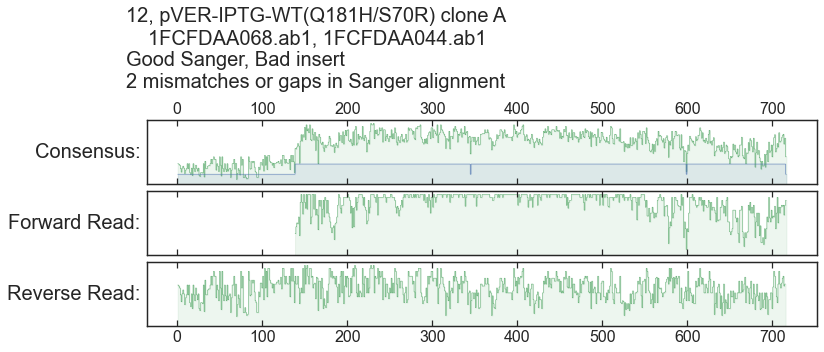

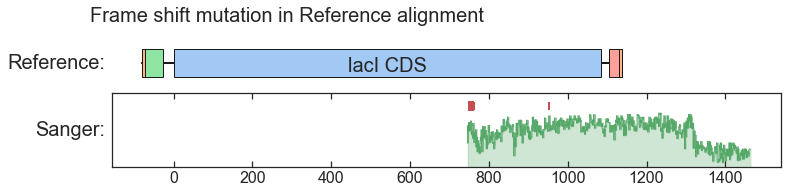

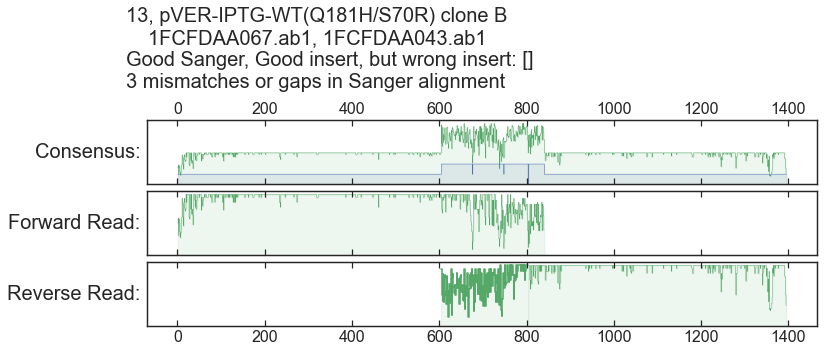

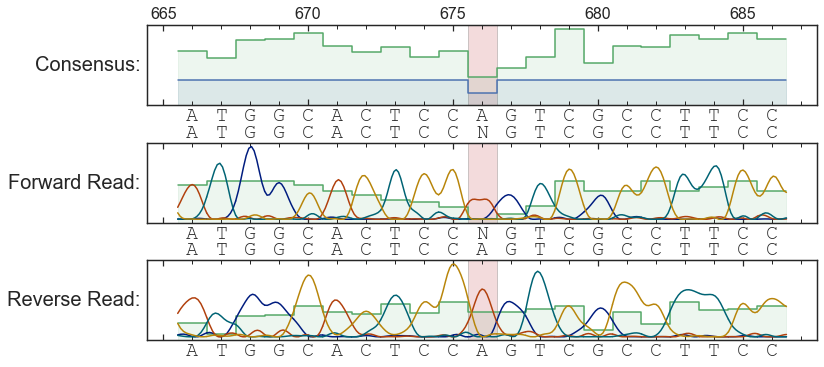

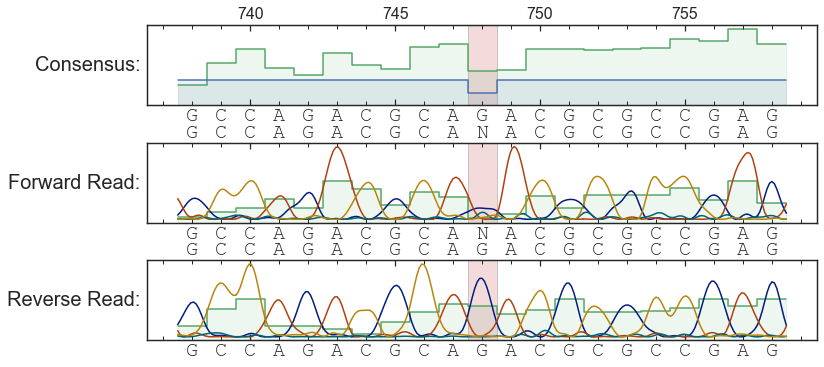

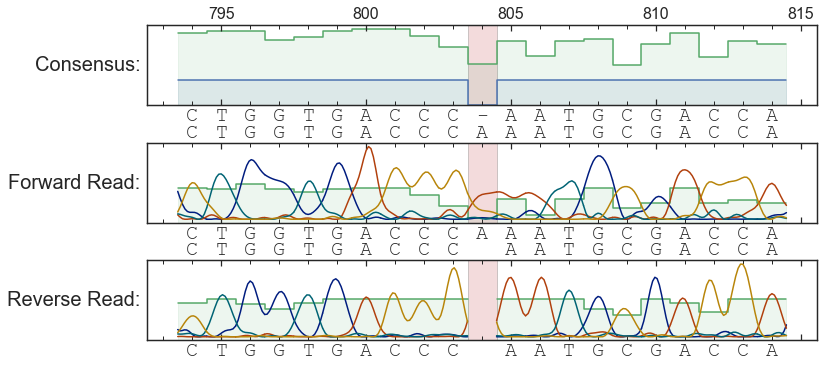

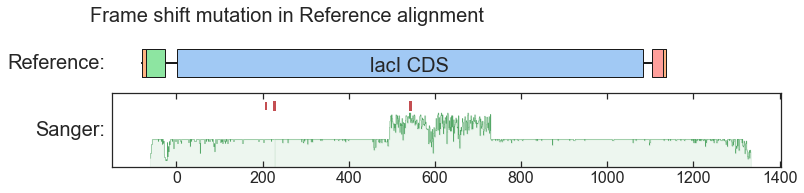

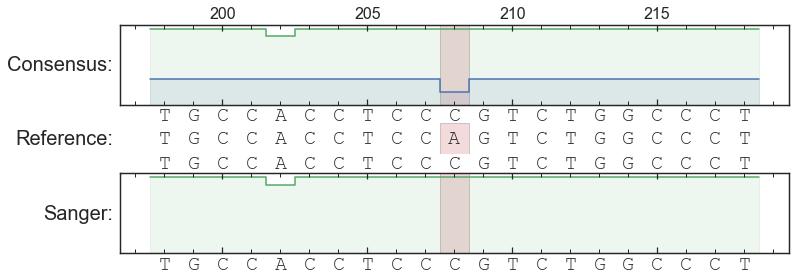

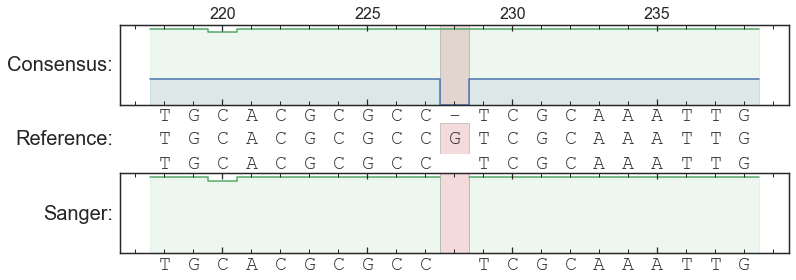

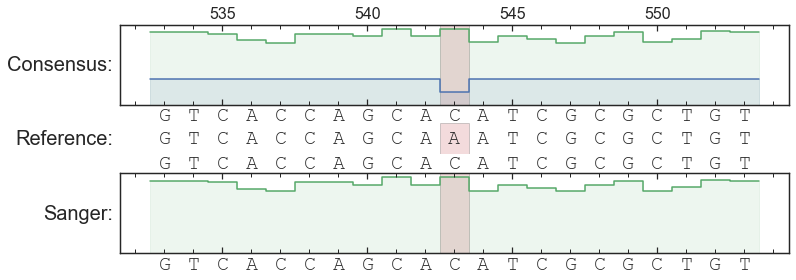

In [23]:
# Plot results
for row_ind, row in align_frame.iterrows():
    a = row.alignment
    f1 = row.forward_sanger_file
    f2 = row.reverse_sanger_file
    
    if a is not None:
        title = f'{row_ind}, {row.variant} clone {row.clone}\n    {f1}, {f2}\n'
        if (row.is_good_sanger):
            title += 'Good Sanger'
        elif (row.is_good_sanger==False):
            title += 'Bad Sanger'
        if (row.is_good_insert):
            title += ', Good insert, '
            if (row.has_correct_insert):
                title += 'and correct insert'
            else:
                title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            title += ', Bad insert'
        ref_align = row.ref_alignment
        gap_count = vs.num_gaps(ref_align)
        title += f'\n{len(a.mismatch_ind)} mismatches or gaps in Sanger alignment'
        
        print(title)
        vs.zoom_out_plot(a, title=title, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        plot_zoom_in = (row.is_good_insert==True)
        if plot_zoom_in:
            for ind in a.mismatch_ind:
                fig, axs = vs.zoom_in_plot(a, ind, verbose=True, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        if (row.gap_in_ref_align==True):
            ref_title = f'Frame shift mutation in Reference alignment'
        if (row.gap_in_ref_align==False):
            ref_title = f'{len(ref_align.mismatch_ind)} mismatches or gaps in Reference alignment'
        print(ref_title)
        vs.compare_to_ref_plot(ref_align, anchor_feature='lacI CDS', title=ref_title);
        
        if plot_zoom_in:
            for ind in ref_align.mismatch_ind:
                fig, axs = vs.zoom_in_plot(ref_align, ind, verbose=True, seq1_label='Reference:', seq2_label='Sanger:',
                                           include_chromatograms=False, compare_to_ref=True, anchor_feature='lacI CDS')

        plt.rcParams["figure.figsize"] = [12, 0.1]
        fig, axs = plt.subplots()
        axs.set_axis_off()

        align_frame.loc[row_ind, 'plotted'] = True

        print()

In [24]:
test = ref_align.f_ind
np.where(test==0)[0][0]

0

In [25]:
align_frame[align_frame.plotted==False][display_cols]

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes,has_correct_insert


In [26]:
out_frame = align_frame[align_frame.plotted==True][display_cols].copy()
good_clone = []
redo_sanger = []
for ind, row in out_frame.iterrows():
    g_cl = ''
    re_sang = ''
    if (row.has_correct_insert==True):
        g_cl = 'Yes'
        re_sang = 'No'
    elif (row.has_correct_insert==False):
        g_cl = 'No'
        re_sang = 'No'
    elif (row.is_good_sanger==True) and (row.is_good_insert==False):
        g_cl = 'No'
        re_sang = 'No'
    elif (row.is_good_sanger==False):
        re_sang = 'Yes'
        
    good_clone.append(g_cl)
    redo_sanger.append(re_sang)
        
out_frame['good_clone'] = good_clone
out_frame['redo_sanger'] = redo_sanger
out_frame.sort_values(by=['variant', 'clone', 'sanger_start'], inplace=True)
out_frame

,variant,clone,forward_sanger_file,reverse_sanger_file,sanger_start,is_good_sanger,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes,has_correct_insert,good_clone,redo_sanger
0,pVER-IPTG-WT(F161V/I83F),A,1FCFDAA056.ab1,1FCFDAA032.ab1,2021-04-26 19:59:48,True,False,True,[],[],None,No,No
1,pVER-IPTG-WT(F161V/I83F),B,1FCFDAA055.ab1,1FCFDAA031.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, F161V]",[],True,Yes,No
2,pVER-IPTG-WT(G200C),A,1FCDDAA051.ab1,1FCDDAA029.ab1,2021-05-14 02:41:37,True,True,False,[G200C],[],True,Yes,No
3,pVER-IPTG-WT(G200C),B,1FCDDAA050.ab1,1FCDDAA028.ab1,2021-05-14 02:41:37,False,None,False,[],[],None,,Yes
4,pVER-IPTG-WT(G200C/I83F),A,1FCFDAA062.ab1,1FCFDAA038.ab1,2021-04-26 19:59:48,True,True,False,"[I83F, G200C]",[],True,Yes,No
5,pVER-IPTG-WT(G200C/I83F),B,1FCFDAA061.ab1,1FCFDAA037.ab1,2021-04-26 19:59:48,False,None,True,[],[],None,,Yes
6,pVER-IPTG-WT(G200C/S97T),A,1FCFDAA004.ab1,1FCDDAA080.ab1,2021-05-05 22:53:10,False,None,True,[],[],None,,Yes
7,pVER-IPTG-WT(G200C/S97T),B,1FCFDAA003.ab1,1FCDDAA079.ab1,2021-05-05 22:53:10,False,None,True,[],[],None,,Yes
8,pVER-IPTG-WT(I83M/S69T),A,1FCFDAA064.ab1,1FCFDAA040.ab1,2021-04-26 19:59:48,True,False,False,[],[],None,No,No
9,pVER-IPTG-WT(I83M/S69T),B,1FCFDAA063.ab1,1FCFDAA039.ab1,2021-04-26 19:59:48,False,None,True,[],[],None,,Yes


In [27]:
os.chdir(notebook_dir)
out_frame.to_csv(clone_file[:-4] + '_report.csv', index=False)

In [28]:
align_frame[ [x is None for x in align_frame.alignment] ]

,variant,clone,forward_sanger_file,reverse_sanger_file,alignment,is_good_sanger,sanger_start,ref_alignment,is_good_insert,gap_in_ref_align,substitution_codes,indel_codes,has_correct_insert,plotted
